Environment and Libraries

In [26]:
#Libraries
import cv2
import os
import glob
import warnings
import scipy.misc
import numpy as np
# # import nibabel as nib
import SimpleITK as sitk
from scipy import ndimage
import matplotlib.pyplot as plt
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
from matplotlib.widgets import Slider
from random import randint
from tqdm import tqdm
import nibabel as nib
import pydicom 

# import keras.api._v2.keras as keras
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from scipy.spatial.distance import directed_hausdorff

if False:
  # Google drive
  from google.colab import drive
  drive.mount('/content/drive')

  # WD for Data
  os.getcwd()
  os.chdir('/content/drive/MyDrive/Colab Notebooks')

  # GPU
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

  # TPU
  # resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  # tf.config.experimental_connect_to_cluster(resolver)
  # # This is the TPU initialization code that has to be at the beginning.
  # tf.tpu.experimental.initialize_tpu_system(resolver)
  # print("All devices: ", tf.config.list_logical_devices('TPU'))

Preprocessing Data

------------------------------
Loading and preprocessing training data...
------------------------------
Patient Scan Data Folders Included in Run:  ['1_AutoBind_WaterWATER_450_15A']


Segmentation Mask:  1_R_tibia_15A
Patient Scan Data:  1_AutoBind_WaterWATER_450_15A
Height of Paitent in mm:  1523.5
Length of Paitent AOI (tibia) in mm:  315.1292724609375


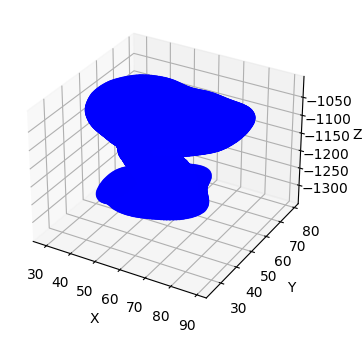

AOI Slice Start:  684
AOI Slice End:  893
AOI Slice Range:  210
Mask Slices Normalized to MRI Scans Shape (Purely AOI):  (210, 512, 512)


Number of Paitents:  1
Training Scans Input Shape:  (1, 1015, 512, 512)
Training Masks Input Shape:  (1, 1015, 512, 512)
Memory usage of training_scans: 1015 MB.
Memory usage of train_mask_tibia_labels: 1015 MB.


Final Training Image Input Shape:  (1015, 512, 512, 1)
Final Training Mask Input Shape:  (1015, 512, 512, 1)
------------------------------
Completed Preprocessing Stage!
------------------------------


In [3]:
from preprocessing import preprocessing
import numpy as np
print('-'*30)
print('Loading and preprocessing training data...')
print('-'*30)

# \\files.auckland.ac.nz\research\resmed202100086-tws ----> Address for raw data
total_slices_raw_data = 1015
DataOnlyAOI = False
scans_path = 'D:/MRI - Tairawhiti'
segmasks_fnames = ['1_R_tibia_15A']
scan_data_folders = ['1_AutoBind_WaterWATER_450_15A']

imgs_train, imgs_mask_train = preprocessing(scans_path, segmasks_fnames, scan_data_folders, total_slices_raw_data, DataOnlyAOI)

#TEMP
# imgs_train = imgs_train[70:80]
# imgs_mask_train = imgs_mask_train[70:80]

if (DataOnlyAOI == False):
    imgs_train = np.reshape(imgs_train, (len(scan_data_folders) * total_slices_raw_data, 512, 512))
    imgs_mask_train = np.reshape(imgs_mask_train, (len(segmasks_fnames) * total_slices_raw_data, 512, 512))
    imgs_train = np.expand_dims(imgs_train, axis=-1)
    imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)

if (DataOnlyAOI == True):
    imgs_train = np.expand_dims(imgs_train, axis=-1)
    imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)

print("\n")
print('Final Training Image Input Shape: ', imgs_train.shape)
print('Final Training Mask Input Shape: ', imgs_mask_train.shape)

print('-'*30)
print('Completed Preprocessing Stage!')
print('-'*30)

In [4]:
from preprocessing import preprocessing
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import cv2
from scipy.spatial import KDTree

seg_masks_15A_tibia = nib.load('D:/MRI - Tairawhiti/Segmentation_2.nii')
seg_masks_15A_tibia_data = seg_masks_15A_tibia.get_fdata()

seg_masks_15A_tibia = sitk.ReadImage('D:/MRI - Tairawhiti/Segmentation_2.nii')
seg_masks_15A_tibia_data = sitk.GetArrayFromImage(seg_masks_15A_tibia)
seg_masks_15A_tibia_data = seg_masks_15A_tibia_data[::-1, :, :]
# seg_masks_15A_tibia_data = np.rot90(seg_masks_15A_tibia_data, k=2, axes=(1, 2))
image_shape = seg_masks_15A_tibia_data.shape
print("Mask NIFTI Input Shape:", image_shape)


def superimpose_images(image1, image2):
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)
    alpha = 0.5
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

def calculate_centroid(mask):
    # Calculate the centroid of the mask
    nonzero_indices = np.nonzero(mask)
    centroid = np.mean(np.stack(nonzero_indices, axis=1), axis=0)
    return centroid

def translate_mask(mask, translation_offset):
    # Translate the mask by the given translation offset
    translated_mask = np.roll(mask, translation_offset.astype(int), axis=(0, 1))
    return translated_mask

def adjust_mask_translation(mask, dicom_image, translation=(0, 0)):
    translated_mask = np.roll(mask, shift=translation, axis=(0, 1))

    # Overlay the translated mask onto the DICOM image for visualization
    overlay = np.where(translated_mask > 0, dicom_image.max(), dicom_image)

    # Plot the DICOM image and the overlay
    if True:
        plt.imshow(overlay, cmap='gray')
        # plt.title('Superimposed Translated Mask and MRI Scan')
        plt.axis('off')
        plt.show()
        print(translated_mask.shape)
        
    return translated_mask

def feature_based_registration(mask, scan_slice):
    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and descriptors for mask and scan_slice
    kp_mask, des_mask = orb.detectAndCompute(mask, None)
    kp_scan_slice, des_scan_slice = orb.detectAndCompute(scan_slice, None)

    # Create a BFMatcher object and match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_mask, des_scan_slice, k=2)

    # Apply ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract matched keypoints' coordinates
    src_pts = np.float32([kp_mask[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_scan_slice[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find the perspective transformation (homography) matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Apply perspective transformation to the mask
    aligned_mask = cv2.warpPerspective(mask, M, (scan_slice.shape[1], scan_slice.shape[0]))

    return aligned_mask

slice = 750

image1 = imgs_train[slice]
image2 = np.expand_dims(seg_masks_15A_tibia_data[slice,:,:], axis=-1)
superimposed_image = superimpose_images(image1, image2)
plt.imshow(superimposed_image, cmap='gray')
plt.axis('off')
plt.show()
print(image1.shape)
# mask_centroid = calculate_centroid(seg_masks_15A_tibia_data[slice,:,:])
# scan_slice_centroid = calculate_centroid(imgs_train[slice,:,:,0])
# translation_offset = scan_slice_centroid - mask_centroid
# aligned_mask = translate_mask(seg_masks_15A_tibia_data[slice,:,:], translation_offset)

# aligned_mask = np.expand_dims(aligned_mask, axis=-1)
# image2 = aligned_mask
# superimposed_image = superimpose_images(image1, image2)
# plt.imshow(superimposed_image, cmap='gray')
# plt.axis('off')
# plt.show()


# translation = (-30, 50)
# translated_mask = adjust_mask_translation(image2, image1, translation)
# superimposed_image = superimpose_images(image1, translated_mask)
# plt.imshow(superimposed_image, cmap='gray')
# plt.axis('off')
# plt.show()

mask = image2[:,:,0]
scan_slice = image1[:,:,0]
aligned_mask = feature_based_registration(mask, scan_slice)

Mask NIFTI Input Shape: (1015, 512, 512)


NameError: name 'plt' is not defined

Data Augmentation

In [35]:
from data_augmentation import DataAugmentation

print('-'*30)
print('Data Augmentation Starting...')
print('-'*30)

num_augmentations = 3
augmented_images_train, augmented_masks_train = DataAugmentation(imgs_train, imgs_mask_train, num_augmentations)

augmented_images_train = np.expand_dims(augmented_images_train, axis=-1)
augmented_masks_train = np.expand_dims(augmented_masks_train, axis=-1)

print('Number of Augmentation per Input: ', num_augmentations)
print('\n')
print('Shape of Augmented Images: ', augmented_images_train.shape)
print('Shape of Augmented Masks: ', augmented_masks_train.shape)
print('\n')
print('Shape of Training Image Data (Before): ', imgs_train.shape)
print('Shape of Training Image Masks (Before): ', imgs_mask_train.shape)
print('\n')

if True:
    imgs_train = np.concatenate((imgs_train, augmented_images_train), axis=0)
    imgs_mask_train = np.concatenate((imgs_mask_train, augmented_masks_train), axis=0)

print('Shape of Training Image Data (After): ', imgs_train.shape)
print('Shape of Training Image Masks (After): ', imgs_mask_train.shape)

print('-'*30)
print('Completed Data Augmentation Stage!')
print('-'*30)

------------------------------
Data Augmentation Starting...
------------------------------


100%|██████████| 840/840 [00:12<00:00, 65.95it/s]


Number of Augmentation per Input:  3


Shape of Augmented Images:  (2520, 512, 512, 1)
Shape of Augmented Masks:  (2520, 512, 512, 1)


Shape of Training Image Data (Before):  (840, 512, 512, 1)
Shape of Training Image Masks (Before):  (840, 512, 512, 1)


Shape of Training Image Data (After):  (3360, 512, 512, 1)
Shape of Training Image Masks (After):  (3360, 512, 512, 1)
------------------------------
Completed Data Augmentation Stage!
------------------------------


Patient Scan Data Folders Included in Run:  ['1_AutoBind_WaterWATER_450_15A']


Segmentation Mask:  1_R_tibia_15A
Patient Scan Data:  1_AutoBind_WaterWATER_450_15A
Height of Paitent in mm:  1523.5
Length of Paitent AOI (tibia) in mm:  315.1292724609375


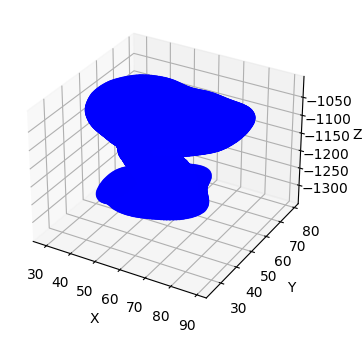

AOI Slice Start:  684
AOI Slice End:  893
AOI Slice Range:  210
Mask Slices Normalized to MRI Scans Shape (Purely AOI):  (210, 512, 512)


Number of Paitents:  1
Training Scans Input Shape:  (210, 512, 512)
Training Masks Input Shape:  (210, 512, 512)
Memory usage of training_scans: 210 MB.
Memory usage of train_mask_tibia_labels: 210 MB.


In [1]:
from gias2.mesh.vtktools import loadpoly
# import utilities
# import utils
from gias2.image_analysis import image_tools as itools
from utils import make_labelled_scan, load_scan
from preprocessing import preprocessing
import os
from os import path
import glob
import numpy as np

total_slices_raw_data = 1015
DataOnlyAOI = True
scans_path = 'D:/MRI - Tairawhiti'
segmasks_fnames = ['1_R_tibia_15A']
scan_data_folders = ['1_AutoBind_WaterWATER_450_15A']
scan, imgs_mask_train, scan_pixelspacing_data = preprocessing(scans_path, segmasks_fnames, scan_data_folders, total_slices_raw_data, DataOnlyAOI)


# s = itools.Scan(path.split('D:/MRI - Tairawhiti/1_AutoBind_WaterWATER_450_15A')[1])
# # Assuming you have the path to the DICOM folder in 'dicom_folder_path'
# dicom_folder_path = 'D:/MRI - Tairawhiti/1_AutoBind_WaterWATER_450_15A'

# # Use glob to find all DICOM files with the pattern 'IM-0049-*.dcm' in the folder
# file_pattern = os.path.join(dicom_folder_path, r'IM-0049-*.dcm')
# dicom_files = glob.glob(file_pattern)
# parent_folder = os.path.dirname(dicom_files[0])
# s.loadDicomFolder(parent_folder)
# s.I = s.I[:, :, ::-1]

# # scan = load_scan('1_AutoBind_WaterWATER_450_15A', pat)
# mesh = loadpoly('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/1_R_tibia_15A.ply')
# meshes_dict = {}
# meshes_dict[0] = mesh


# zshift = False
# negspacing = False
# scan_lab = make_labelled_scan(meshes_dict, s, zshift, negspacing)

# mask_1 = scan_lab.I == 2

# import cv2
# import matplotlib.pyplot as plt
# import trimesh
# import pandas as pd

# from preprocessing import ReadIn_MRIScans_Masks
# scan_data_folders = ['1_AutoBind_WaterWATER_450_15A']
# scans_path = 'D:/MRI - Tairawhiti'

# training_scans, coord_data = ReadIn_MRIScans_Masks(scans_path, scan_data_folders[0])

# # masks = []
# # for slice in training_scans:
# ply_file = 'C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/1_R_tibia_15A.ply'
# mesh = trimesh.load_mesh(ply_file)
# vertices = mesh.vertices

# ply_file = 'C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/1_R_tibia_15A.ply'
# mesh = trimesh.load_mesh(ply_file)
# vertices = mesh.vertices
# faces = mesh.faces
# print("Vertices shape:", vertices.shape)

Superimposed Mask Visualisation 

C:\Users\GGPC\AppData\Local\Temp\ipykernel_15020\3818310433.py:3: RuntimeWarning: invalid value encountered in true_divide
  image1 = image1 / np.max(image1)


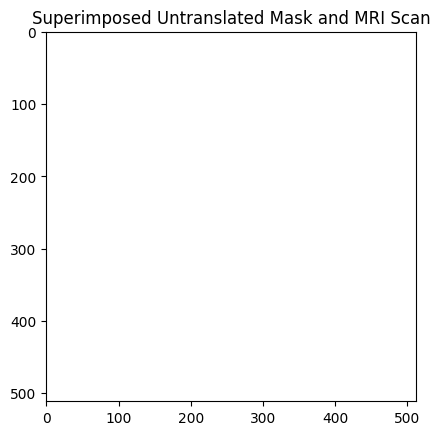

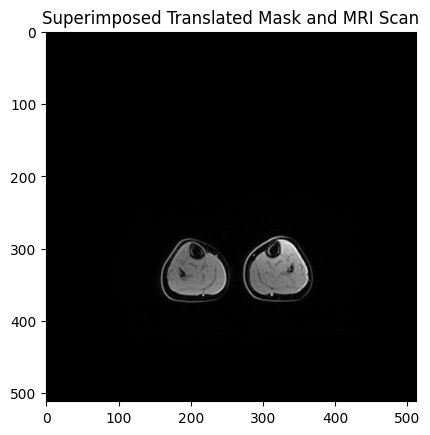

(512, 512, 1)


(-0.5, 511.5, 511.5, -0.5)

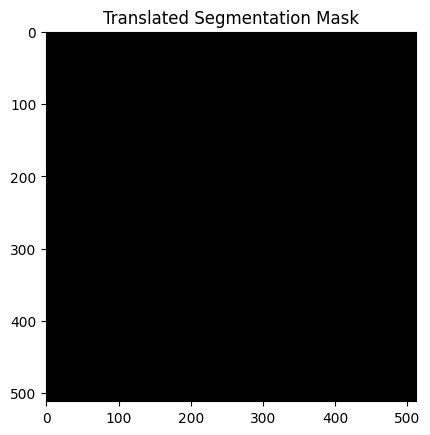

In [4]:
def superimpose_images(image1, image2):
    # Normalize the image intensities to range [0, 1]
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)

    # Create a new image by overlaying image1 on image2
    alpha = 0.5  # Opacity of image1
    superimposed_image = alpha * image1 + (1 - alpha) * image2

    return superimposed_image

# Load the MRI scans as NumPy arrays
# image1 = np.loadtxt('D:/P4P Model Data/txt/Masks_Tibia/data_200.txt', delimiter=',')
# image2 = np.loadtxt('D:/P4P Model Data/txt/Data_Tibia/data_200.txt', delimiter=',')
# image1 = np.loadtxt('D:/P4P Model Data/txt/Masks_Tibia/data_60.txt', delimiter=',')
# image2 = np.loadtxt('D:/P4P Model Data/txt/Data_Tibia/data_60.txt', delimiter=',')
# image1 = np.loadtxt('D:/P4P Model Data/txt/Masks_Tibia/data_20.txt', delimiter=',')
# image2 = np.loadtxt('D:/P4P Model Data/txt/Data_Tibia/data_20.txt', delimiter=',')
image1 = imgs_mask_train[70]
image2 = imgs_train[70]

# Superimpose the images
superimposed_image = superimpose_images(image1, image2)

# Visualize the superimposed image
plt.imshow(superimposed_image, cmap='gray')
plt.title('Superimposed Untranslated Mask and MRI Scan')
plt.axis('on')
plt.show()


def adjust_mask_translation(mask, dicom_image, translation=(0, 0)):
    translated_mask = np.roll(mask, shift=translation, axis=(0, 1))

    # Overlay the translated mask onto the DICOM image for visualization
    overlay = np.where(translated_mask > 0, dicom_image.max(), dicom_image)

    # Plot the DICOM image and the overlay
    if True:
        plt.imshow(overlay, cmap='gray')
        plt.title('Superimposed Translated Mask and MRI Scan')
        plt.axis('on')
        plt.show()
        print(translated_mask.shape)
        
    return translated_mask


translation = (55, 55)
# translation = (-293, -293)
translated_mask = adjust_mask_translation(image1, image2, translation)
# grayscale_image = np.loadtxt('D:/P4P Model Data/txt/Mask_Tibia(Collab Sample)/data_100.txt', delimiter=',')
fig, ax = plt.subplots()
img = ax.imshow(translated_mask, cmap='gray')
plt.title('Translated Segmentation Mask')
ax.axis('on')

Exporting out Labelled Datasets

In [5]:
# Exporting Training Scan and Mask Data
from writeout_dataset import WriteOutTextFile
from writeout_dataset import WriteOutImagePNGFiles

translation = (55, 55)
for i in range(len(imgs_mask_train)):
    # print(imgs_mask_train[i].shape)
    # print(imgs_train[i].shape)
    imgs_mask_train[i] = adjust_mask_translation(imgs_mask_train[i], imgs_train[i], translation)

starting_slice = 70
save_directory_data_txt = 'D:/P4P Model Data/txt/Data_Tibia(Collab Sample)'
# save_directory_data_img = 'D:/P4P Model Data/img/Data'
save_directory_mask_txt = 'D:/P4P Model Data/txt/Mask_Tibia(Collab Sample)'
# save_directory_mask_img = 'D:/P4P Model Data/img/Masks'

WriteOutTextFile(imgs_train[:, :, :, 0], save_directory_data_txt, starting_slice)   
# # WriteOutImagePNGFiles(imgs_train, save_directory_data_img)

WriteOutTextFile(imgs_mask_train[:, :, :, 0], save_directory_mask_txt, starting_slice)   
# # WriteOutImagePNGFiles(imgs_mask_train, save_directory_mask_img)

Data Validation (Visual Sanity Check)

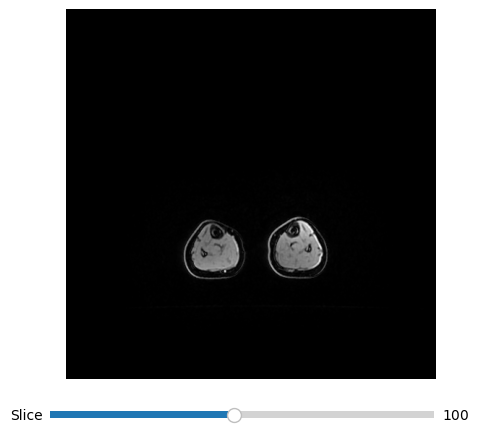

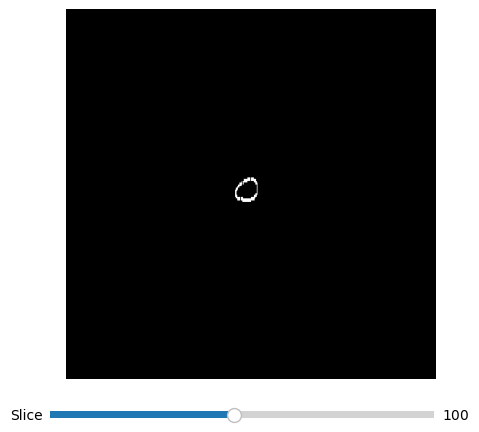

In [8]:
# Visualiser Tool Scan
temp = np.squeeze(imgs_train)
current_slice = 100

fig, ax = plt.subplots()
current_slice = 100
img = ax.imshow(temp[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, temp.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

# Visualiser Tool Mask
temp = np.squeeze(imgs_mask_train)
fig, ax = plt.subplots()
current_slice = 100
img = ax.imshow(temp[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, temp.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

2DUNet Model

In [9]:
# Define U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Dice Coefficient Loss Function
def dice_loss(y_true, y_pred):
    smooth = 1e-5  # Adding a small constant to avoid division by zero
    print(y_true.shape)
    print(y_pred.shape)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    print(intersection)
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - tf.reduce_mean(dice_coefficient)
    return loss

2D Dense UNet

In [ ]:
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout

def dense_block(x, filters, dropout_rate):
    conv1 = Conv2D(filters, 3, activation='relu', padding='same')(x)
    conv2 = Conv2D(filters, 3, activation='relu', padding='same')(conv1)
    concat = Concatenate(axis=-1)([x, conv2])
    if dropout_rate:
        concat = Dropout(dropout_rate)(concat)
    return concat

def dense_unet(input_shape, num_classes, filters=16, num_layers=4, dropout_rate=0.2):
    inputs = Input(input_shape)
    skip_connections = []

    # Downward path
    x = inputs
    for _ in range(num_layers):
        x = dense_block(x, filters, dropout_rate)
        skip_connections.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        filters *= 2

    # Bridge
    x = dense_block(x, filters, dropout_rate)

    # Upward path
    for i in range(num_layers):
        filters //= 2
        x = UpSampling2D(size=(2, 2))(x)
        x = Concatenate(axis=-1)([x, skip_connections.pop()])
        x = dense_block(x, filters, dropout_rate)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from writeout_dataset import ReadInDatasets
imgs_train = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Data_Tibia (1)', 1, 500)
imgs_mask_train = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Masks_Tibia (1)', 1, 500)
# imgs_train = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Data_Tibia(Collab Sample)')
# imgs_mask_train = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Mask_Tibia(Collab Sample)')
# imgs_test = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Data_Tibia(Collab Sample)')

imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)
imgs_train = np.expand_dims(imgs_train, axis=-1)

# import backbones_unet
# print(backbones_unet.__available_models__)

print('imgs_train size: ', imgs_train.shape)
print('imgs_mask_train size: ', imgs_mask_train.shape)

In [ ]:
print('-'*30)
print('Training UNet Model...')
print('-'*30)

images_train, images_val, labels_train, labels_val = train_test_split(imgs_train, imgs_mask_train, test_size=0.2, random_state=0)
print('Training Image Input Shape: ', images_train.shape)
print('Training Mask Input Shape: ', labels_train.shape)
print('Validation Image Input Shape: ', images_val.shape)
print('Validation Mask Input Shape: ', labels_val.shape)


print('-'*30)
print('Creating and compiling model...')
print('-'*30)

# my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=PATIENCE), # early stopping
#     tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True) # save the best based on validation
# ]

input_shape = (512,512,1)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy')
# model.compile(optimizer='adam', loss=dice_loss)
checkpoint = ModelCheckpoint('model(loss=binary,batch_size=4,epochs=20,train_size=500,aoi=tibia).h5', monitor='val_loss', save_best_only=True, mode='min')
model.fit(x=images_train, y=labels_train, batch_size=4, epochs=20, validation_data=(images_val, labels_val), callbacks=[checkpoint])
model.summary()

# Dense 2D UNet
# input_shape = (512,512,1)
# num_classes = 1
# model = dense_unet(input_shape, num_classes)
# model.compile(optimizer='adam', loss='binary_crossentropy')
# checkpoint = ModelCheckpoint('model(Baseline + 2D Dense Layers 125 Epoch).h5', monitor='val_loss', save_best_only=True, mode='min')
# model.fit(x=images_train, y=labels_train, batch_size=1, epochs=125, validation_data=(images_val, labels_val), callbacks=[checkpoint])
# model.summary()

Prediction Mask

In [ ]:
# model = 'best_model.h5'
# model = 'model(loss=binary,batch_size=4,epochs=20,train_size=500,aoi=tibia).h5'
# model = 'model(Baseline + 2D Dense Layers).h5'
model = 'model(Baseline 125 Epoch).h5'
# model = 'model(Baseline + 2D Dense Layers 125 Epoch).h5'
pred_img_idx = -1

from writeout_dataset import ReadInDatasets
imgs_test = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Data_Tibia(Collab Sample)', 0, 10)
imgs_test_masks = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Masks_Tibia(Collab Sample)', 0, 10)
testing_scans_processed = np.reshape(imgs_test, (len(imgs_test), 512, 512, 1))
testing_masks_processed = np.reshape(imgs_test_masks, (len(imgs_test), 512, 512, 1))
print('testing_masks_processed size: ', testing_scans_processed.shape)
print('testing_masks_processed size: ', testing_masks_processed.shape)

def superimpose_images(image1, image2):
    # Normalize the image intensities
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)

    alpha = 0.5  # Opacity of raw scan
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

print('-'*30)
print(f'Prediction Made Using Weights From Model: {model}')
print('-'*30)

print('Testing Image Input Shape: ',(np.reshape(testing_scans_processed[pred_img_idx], (1,512,512,1))).shape)

# Prediction
best_model = load_model(model)
prediction = best_model.predict(np.reshape(testing_scans_processed[pred_img_idx], (1,512,512,1)))
print('Testing Image Input Shape: ',testing_scans_processed[pred_img_idx].shape)
# print('Prediction Mask Shape: ', prediction.shape)
print('\n')

# Evaluation
rounded_array  = np.round(prediction, decimals=3)
binary_pred = np.where(rounded_array > 0, 1, 0)
DSC = dice_coefficient((np.reshape(testing_masks_processed[pred_img_idx], (1,512,512,1))), binary_pred)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

# Visualisations
cmap_binary = 'white'
cmap_segmask = plt.cm.colors.ListedColormap(['black', cmap_binary])
bounds = [0, 0.5, 1]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap_segmask.N)
fig, ax = plt.subplots()
ax.imshow(binary_pred[0, :, :, 0], cmap=cmap_segmask, norm=norm)
ax.axis('on')
plt.title('Model Outputted Segmentation Mask')
plt.show()

fig, ax = plt.subplots()
ax.imshow(testing_masks_processed[pred_img_idx, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Groundtruth Mask')
plt.show()

fig, ax = plt.subplots()
ax.imshow(testing_scans_processed[pred_img_idx, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Raw Test Scan')
plt.show()

cmap_binary = 'YlOrBr'
superimposed_image = superimpose_images(testing_masks_processed[pred_img_idx, :, :, 0], binary_pred[0, :, :, 0])
# Define the cropping ranges
x_start, x_end = 200, 400
y_start, y_end = 200, 400
cropped_image = superimposed_image[y_start:y_end, x_start:x_end]
fig, ax = plt.subplots()
cmap_superimposed = plt.cm.get_cmap(cmap_binary)
ax.imshow(cropped_image, cmap=cmap_superimposed, vmin=0, vmax=1)
ax.axis('on')
plt.title('Superimposed Prediction Mask (Orange) & Groundtruth Mask (Black)')
plt.show()

fig, ax = plt.subplots()
superimposed_image = superimpose_images(testing_scans_processed[pred_img_idx, :, :, 0], testing_masks_processed[pred_img_idx, :, :, 0])
ax.imshow(superimposed_image, cmap='gray')
ax.axis('on')
plt.title('Superimposed Raw Test Scan & Groundtruth Mask (Manually Segmented)')
plt.show()

fig, ax = plt.subplots()
superimposed_image = superimpose_images(testing_scans_processed[pred_img_idx, :, :, 0], binary_pred[0, :, :, 0])
ax.imshow(superimposed_image, cmap='gray')
ax.axis('on')
plt.title('Superimposed Raw Test Scan & Prediction Mask (Automatically Segmented)')
plt.show()

Evaluation Metrics

In [88]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

def assd(y_true, y_pred, spacing):
    surface_distances = surface_distance(y_true, y_pred, spacing)
    avg_surface_distance = np.mean(surface_distances)
    return avg_surface_distance

def surface_distance(y_true, y_pred, spacing):
    true_surface = find_surface_points(y_true, spacing)
    pred_surface = find_surface_points(y_pred, spacing)

    if true_surface.shape[0] == 0 or pred_surface.shape[0] == 0:
        raise ValueError("One or both surface point arrays are empty.")

    try:
        surface_distances_true_to_pred = directed_hausdorff(true_surface, pred_surface)[0]
        surface_distances_pred_to_true = directed_hausdorff(pred_surface, true_surface)[0]
        surface_distances = np.concatenate([surface_distances_true_to_pred, surface_distances_pred_to_true])
    except ValueError as e:
        print("Error occurred during Hausdorff distance calculation:", e)
        raise

    return surface_distances

def find_surface_points(mask, spacing):
    mask_padded = np.pad(mask, 1, mode='constant')
    mask_padded_diff = np.diff(mask_padded.astype(int), axis=0)

    surface_points = []
    for z in range(mask_padded_diff.shape[0]):
        surface_indices = np.where(mask_padded_diff[z] != 0)
        if len(surface_indices[0]) > 0:
            surface_points.extend(list(zip(surface_indices[0], surface_indices[1])))

    surface_points = np.array(surface_points)
    surface_points_phys = surface_points * spacing

    return surface_points_phys

def volume_error(y_true, y_pred):
    true_volume = np.sum(y_true)
    pred_volume = np.sum(y_pred)
    volume_error = np.abs(true_volume - pred_volume) / true_volume
    return volume_error

predictions_single_scan_binarized = np.reshape(predictions_single_scan_binarized,(1, 512, 512, 1))
DSC = dice_coefficient(testing_masks_processed, predictions_single_scan_binarized)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

# VError = volume_error(testing_masks_processed, prediction)
# print('Volume Error (VError) Metric Value: ', VError)
# print('\n')

# spacing = 1
# ASSD = assd(testing_masks_processed, prediction, spacing)
# print('Average Symmetric Surface Distance (ASSD) Metric Value: ', ASSD)
# print('\n')

Dice Similarity Coefficient (DSC) Metric Value:  [4.0989216e-06]




In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
# from keras.layers.core import Dropout
# import tensorflow as tf
# # from tensorflow.keras.models import Model
# from keras.layers import *
# from keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define U-Net model
# def unet_model(input_shape):
#     inputs = Input(input_shape)
    
#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
#     # Bottleneck
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)
    
#     # Decoder
#     up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
#     up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv3, up7], axis=3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
#     up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
#     up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
#     merge9 = concatenate([conv1, up9], axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
#     outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
#     model = Model(inputs=inputs, outputs=outputs)
    
#     return model

# # Dice Coefficient Loss Function 
# def dice_coefficient(y_true, y_pred):
#     smooth = 1e-5
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1.0 - dice


# # Reformat image data structure
# training_scans_reshaped = np.concatenate(preprocessed_images, axis=0)
# training_scans = training_scans_reshaped.reshape((-1, 512, 512, 1))
# train_mask_tibia_labels_reshaped = np.concatenate(preprocessed_masks, axis=0)
# train_mask_tibia_labels = train_mask_tibia_labels_reshaped.reshape((-1, 512, 512, 1))

# # Split the data into training and validation sets\
# images_train, images_val, labels_train, labels_val = train_test_split(training_scans, train_mask_tibia_labels, test_size=0.2, random_state=0)
# unseen_scan_model = np.array(training_scans[2][100])
# images_train = images_train.astype('float32') / 255.0
# images_val = images_val.astype('float32') / 255.0

# print(images_train.shape)
# print(labels_train.shape)
# print(images_train.dtype)
# print(labels_train.dtype)
# print(images_val.shape)
# print(labels_val.shape)
# print(images_val.dtype)
# print(labels_val.dtype)
# print(unseen_scan_model.shape)

# # Expand dimensions for the channel (grayscale) dimension
# # images_train = np.expand_dims(images_train, axis=-1)
# # images_val = np.expand_dims(images_val, axis=-1)
# # labels_train = np.expand_dims(labels_train, axis=-1)
# # labels_val = np.expand_dims(labels_val, axis=-1)

# # Create an instance of the U-Net model
# input_shape = (512, 512, 1)  # For grayscale images

# # Create an instance of the U-Net model
# model = unet_model(input_shape)

# # Compile the model
# # Binary Cross Entropy Loss Function
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Dice Coefficient Loss Function
# # model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# # Train the model
# # Hyperparameter tuning -> batch_size
# model.fit(x=images_train, y=labels_train, batch_size=32, epochs=1, validation_data=(images_val, labels_val))
# # Evaluate the model
# loss, accuracy = model.evaluate(x=images_val, y=labels_val)

# # Perform inference on new, unseen MRI scans
# predictions = model.predict(unseen_scan_model)

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
# from keras.layers.core import Dropout
# import tensorflow as tf
# # from tensorflow.keras.models import Model
# from keras.layers import *
# from keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define U-Net model
# def unet_model(input_shape):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     # Bottleneck
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     # Decoder
#     up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

#     up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv3, up7], axis=3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

#     up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

#     up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
#     merge9 = concatenate([conv1, up9], axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

#     outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

#     model = Model(inputs=inputs, outputs=outputs)

#     return model

# # Dice Coefficient Loss Function
# def dice_coefficient(y_true, y_pred):
#     smooth = 1e-5
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1.0 - dice


# # Reformat image data structure
# training_scans_reshaped = np.concatenate(preprocessed_images, axis=0)
# training_scans = training_scans_reshaped.reshape((-1, 512, 512, 1))
# train_mask_tibia_labels_reshaped = np.concatenate(preprocessed_masks, axis=0)
# train_mask_tibia_labels = train_mask_tibia_labels_reshaped.reshape((-1, 512, 512, 1))

# # Split the data into training and validation sets\
# images_train, images_val, labels_train, labels_val = train_test_split(training_scans, train_mask_tibia_labels, test_size=0.2, random_state=0)
# unseen_scan_model = np.array(training_scans[2][100])
# images_train = images_train.astype('float32') / 255.0
# images_val = images_val.astype('float32') / 255.0

# print(images_train.shape)
# print(labels_train.shape)
# print(images_train.dtype)
# print(labels_train.dtype)
# print(images_val.shape)
# print(labels_val.shape)
# print(images_val.dtype)
# print(labels_val.dtype)
# print(unseen_scan_model.shape)

# # Expand dimensions for the channel (grayscale) dimension
# # images_train = np.expand_dims(images_train, axis=-1)
# # images_val = np.expand_dims(images_val, axis=-1)
# # labels_train = np.expand_dims(labels_train, axis=-1)
# # labels_val = np.expand_dims(labels_val, axis=-1)

# # Create an instance of the U-Net model
# input_shape = (512, 512, 1)  # For grayscale images

# # Create an instance of the U-Net model
# model = unet_model(input_shape)

# # Compile the model
# # Binary Cross Entropy Loss Function
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Dice Coefficient Loss Function
# # model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# # Train the model
# # Hyperparameter tuning -> batch_size
# model.fit(x=images_train, y=labels_train, batch_size=32, epochs=1, validation_data=(images_val, labels_val))
# # Evaluate the model
# loss, accuracy = model.evaluate(x=images_val, y=labels_val)

# # Perform inference on new, unseen MRI scans
# predictions = model.predict(unseen_scan_model)